# Bet Lehem Station

In this notebook we will be looking at Bet Lehem station which is in The Dead Sea area. Since we don't have rainfall data, we will use flow and water level data only from 1964 to 2018.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd "/content/drive/My Drive/Colab Notebooks"

/content/drive/My Drive/Colab Notebooks


In [ ]:
!pip install import-ipynb
import import_ipynb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 8.7 MB/s eta 0:00:00


In [ ]:
from functions import *

importing Jupyter notebook from functions.ipynb


In [ ]:
# fix random seed for reproducibility
seed = 10
np.random.seed(seed)
tf.random.set_seed(seed)

Loading the data after preprocessing:

In [ ]:
path_flow = '/content/drive/MyDrive/FinalProjectDataScience/flow_in_hydro_stations.xlsx'
df = pd.read_excel(path_flow)

In [ ]:
df_flow = df.copy(deep=True)

In [ ]:
df_flow.head()

,gauge_id,time,flow,water_level
0,2105,1966-10-01 00:00:00,0.000,0.00
1,2105,1966-12-19 18:35:00,0.027,2.88
2,2105,1966-12-19 18:35:00,0.027,0.00
3,2105,1966-12-19 18:45:00,0.037,2.90
4,2105,1966-12-19 19:00:00,0.037,2.90


In [ ]:
path_catalog = '/content/drive/MyDrive/FinalProjectDataScience/hydro_stations_catalog.xlsx'
df_catalog = pd.read_excel(path_catalog)

In [ ]:
df_catalog.head()

,זיהוי תחנה,שם עברית,שם אנגלית,שם קודם,תאריך הקמה,שטח היקוות (קמר),X .נ.צ,Y .נ.צ,קשר עם תחנה קודמת,תחום התנקזות ראשי,סטטוס תחנה
0,1102,בצת-כביש 4,BEZET- ROAD 4,כרכרה,27/01/2015,102.0,211086.0,775565.0,NaN,בצת,לא פעילה
1,1105,בצת - ע''י אילון,BEZET - NEAR AYYALON,NaN,01/10/1949,71.0,221150.0,775650.0,NaN,בצת,לא פעילה
2,1106,בצת - ע''י חורבת כרכרה,BEZET - NEAR AYYALON,NaN,01/10/1944,71.0,220950.0,775350.0,NaN,בצת,לא פעילה
3,2105,כזיב - גשר הזיו,KEZIV - HAZIV BRIDGE,כביר,01/10/1966,130.0,210315.0,772922.0,NaN,כזיב,פעילה
4,2106,כזיב - גשר הרכבת,KEZIV - RAILWAY BRIDGE,כביר,01/10/1944,131.0,210100.0,772800.0,2105.0,כזיב,לא פעילה


# Pipeline

1. Choose lead time by taking the lead time with the highest mean persistNSE score.
2. Run LSTM model.
3. Run GRU model.
4. Compare between the models.

## Hyperparameters

In [ ]:
# Time Resolution
time_resolution = '1H'

# Number of sequences in the data per hour (depends on time resolution)
sequences_per_hour = 1

# Lead time (by hours)
l = 3

# Number of epochs
epochs = 5

# Batch size
batch_size = 256

# Number of years to train over
n_train_years = 37

# size of validation set - leave 1 year out
validation_split = 1 / n_train_years

## Preprocess

In [ ]:
gauge_id = 8140
gauge_name = df_catalog[df_catalog['זיהוי תחנה'] == gauge_id]['שם אנגלית'].iloc[0]

In [ ]:
gauge_df = get_data_of_gauge(gauge_id, df_flow)
gauge_df.drop(columns=['gauge_id'], inplace=True)

<ipython-input-11-4c22817b4a30>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gauge_df.drop(columns=['gauge_id'], inplace=True)


In [ ]:
# Set 'timestamp' as the DataFrame index
gauge_df['time'] = pd.to_datetime(gauge_df['time'])

<ipython-input-12-cfd5998e3239>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gauge_df['time'] = pd.to_datetime(gauge_df['time'])


In [ ]:
gauge_df = resample_data(gauge_df, time_resolution)

In [ ]:
gauge_df

,flow,water_level
time,,
1964-11-19 00:00:00,0.0100,10.100
1964-11-19 01:00:00,0.0114,10.105
1964-11-19 02:00:00,0.0128,10.110
1964-11-19 03:00:00,0.0142,10.115
1964-11-19 04:00:00,0.0156,10.120
...,...,...
2018-10-08 07:00:00,0.0161,10.110
2018-10-08 08:00:00,0.0161,10.110
2018-10-08 09:00:00,0.0161,10.110


In [ ]:
# prepare loss function
std = gauge_df['flow'].std()
nse_star = get_nse_loss(std)

In [ ]:
# prepare nse metric
mean = gauge_df['flow'].mean()
nse_tensor = get_nse_tensor(mean)
nse_numpy = get_nse_numpy(mean)

## Choice of Lead Time

In [ ]:
nse_means = {1:0, 2:0, 3:0}
persist_nse_means = {1:0, 2:0, 3:0}
n_iter = 3

for i in range(n_iter):
  for lead_time in range(1, 4):
    # number of lag hours
    n_hours = lead_time * sequences_per_hour
    reframed, scaler = prepare_data(gauge_df, n_hours)

    # number of total features
    n_features = len(gauge_df.columns)

    # drop columns of reframed that are not for prediction
    n_cols_reframed = len(reframed.columns)
    reframed.drop(reframed.columns[n_cols_reframed-n_features+1:], axis=1, inplace=True)

    # split into train and test sets
    n_train_sequences = n_train_years * DAYS_PER_YEAR * HOURS_PER_DAY * sequences_per_hour
    train_X, train_y, test_X, test_y = split_train_and_test(reframed, n_train_sequences, n_hours, n_features)

    # prepare creating model
    metrics = [persistent_nse_tensor, nse_tensor]
    create_model = build_model(train_X, nse_star, metrics, LSTM)

    # run model
    model = create_model()
    history = model.fit(train_X, train_y, epochs=epochs, batch_size=batch_size, validation_split=validation_split, verbose=2, shuffle=False)

    # make a prediction
    yhat = model.predict(test_X)
    test_X = test_X.reshape((test_X.shape[0], n_hours*n_features))

    # invert scaling for forecast
    inv_yhat = np.concatenate((yhat, test_X[:, -(n_features-1):]), axis=1)
    inv_yhat = scaler.inverse_transform(inv_yhat)
    inv_yhat = inv_yhat[:,0]

    # invert scaling for actual
    test_y = test_y.reshape((len(test_y), 1))
    inv_y = np.concatenate((test_y, test_X[:, -(n_features-1):]), axis=1)
    inv_y = scaler.inverse_transform(inv_y)
    inv_y = inv_y[:,0]

    # calculate NSE
    nse_numpy = get_nse_numpy(mean)
    nse_metric = nse_numpy(inv_y, inv_yhat)
    nse_means[lead_time] += nse_metric/n_iter

    # calculate persistNSE
    persist_nse_metric = persistent_nse_numpy(inv_y, inv_yhat)
    persist_nse_means[lead_time] += persist_nse_metric/n_iter

Epoch 1/5
1232/1232 - 15s - loss: 0.1168 - persistent_nse_tensor: 0.8764 - nse_tensor: 0.9668 - val_loss: 0.0043 - val_persistent_nse_tensor: 0.9888 - val_nse_tensor: 0.9993 - 15s/epoch - 13ms/step
Epoch 2/5
1232/1232 - 15s - loss: 0.0636 - persistent_nse_tensor: 0.9343 - nse_tensor: 0.9824 - val_loss: 0.0047 - val_persistent_nse_tensor: 0.9878 - val_nse_tensor: 0.9993 - 15s/epoch - 12ms/step
Epoch 3/5
1232/1232 - 15s - loss: 0.0421 - persistent_nse_tensor: 0.9588 - nse_tensor: 0.9884 - val_loss: 0.0024 - val_persistent_nse_tensor: 0.9938 - val_nse_tensor: 0.9996 - 15s/epoch - 12ms/step
Epoch 4/5
1232/1232 - 13s - loss: 0.0413 - persistent_nse_tensor: 0.9611 - nse_tensor: 0.9882 - val_loss: 0.0023 - val_persistent_nse_tensor: 0.9939 - val_nse_tensor: 0.9996 - 13s/epoch - 10ms/step
Epoch 5/5
1232/1232 - 19s - loss: 0.0374 - persistent_nse_tensor: 0.9625 - nse_tensor: 0.9885 - val_loss: 0.0024 - val_persistent_nse_tensor: 0.9937 - val_nse_tensor: 0.9996 - 19s/epoch - 15ms/step
4633/4633 

In [ ]:
nse_means

{1: 0.9020717243507925, 2: 0.9429417433926439, 3: 0.9687215677318708}

In [ ]:
persist_nse_means

{1: 0.9035792826973319, 2: 0.9438201332904558, 3: 0.9692030902753355}

We can see that the best choice for lead time by both mean scores is 3 hours.

## LSTM

In [ ]:
# number of lag hours
n_hours = l * sequences_per_hour
reframed, scaler = prepare_data(gauge_df, n_hours)

# number of total features
n_features = len(gauge_df.columns)

# drop columns of reframed that are not for prediction
n_cols_reframed = len(reframed.columns)
reframed.drop(reframed.columns[n_cols_reframed-n_features+1:], axis=1, inplace=True)

print(reframed.head())

# split into train and test sets
n_train_sequences = n_train_years * DAYS_PER_YEAR * HOURS_PER_DAY * sequences_per_hour
train_X, train_y, test_X, test_y = split_train_and_test(reframed, n_train_sequences, n_hours, n_features)

   var1(t-3)  var2(t-3)  var1(t-2)  var2(t-2)  var1(t-1)  var2(t-1)   var1(t)
3   0.000375   0.821138   0.000427   0.821545   0.000479   0.821951  0.000532
4   0.000427   0.821545   0.000479   0.821951   0.000532   0.822358  0.000584
5   0.000479   0.821951   0.000532   0.822358   0.000584   0.822764  0.000637
6   0.000532   0.822358   0.000584   0.822764   0.000637   0.823171  0.000689
7   0.000584   0.822764   0.000637   0.823171   0.000689   0.823577  0.000742


In [ ]:
# prepare creating model
metrics = [persistent_nse_tensor, nse_tensor]
create_model = build_model(train_X, nse_star, metrics, LSTM)

# run model
model = create_model()
history = model.fit(train_X, train_y, epochs=epochs, batch_size=batch_size, validation_split=validation_split, verbose=2, shuffle=False)

Epoch 1/5
1232/1232 - 6s - loss: 0.1223 - persistent_nse_tensor: 0.8012 - nse_tensor: 0.9730 - val_loss: 0.0069 - val_persistent_nse_tensor: 0.9820 - val_nse_tensor: 0.9989 - 6s/epoch - 5ms/step
Epoch 2/5
1232/1232 - 3s - loss: 0.0479 - persistent_nse_tensor: 0.9322 - nse_tensor: 0.9886 - val_loss: 0.0054 - val_persistent_nse_tensor: 0.9858 - val_nse_tensor: 0.9991 - 3s/epoch - 3ms/step
Epoch 3/5
1232/1232 - 4s - loss: 0.0412 - persistent_nse_tensor: 0.9459 - nse_tensor: 0.9908 - val_loss: 0.0029 - val_persistent_nse_tensor: 0.9923 - val_nse_tensor: 0.9995 - 4s/epoch - 3ms/step
Epoch 4/5
1232/1232 - 3s - loss: 0.0348 - persistent_nse_tensor: 0.9564 - nse_tensor: 0.9919 - val_loss: 0.0028 - val_persistent_nse_tensor: 0.9926 - val_nse_tensor: 0.9995 - 3s/epoch - 3ms/step
Epoch 5/5
1232/1232 - 3s - loss: 0.0313 - persistent_nse_tensor: 0.9661 - nse_tensor: 0.9922 - val_loss: 0.0027 - val_persistent_nse_tensor: 0.9928 - val_nse_tensor: 0.9996 - 3s/epoch - 3ms/step


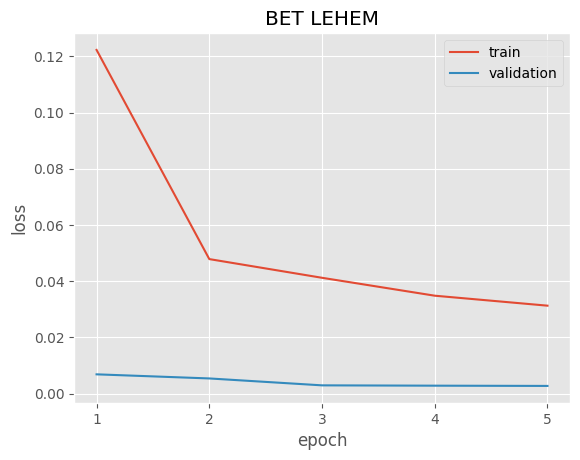

In [ ]:
plot_history(epochs, history, gauge_name)

4633/4633 [==============================] - 8s 2ms/step
Test NSE: 0.972
Test PersistentNSE: 0.973


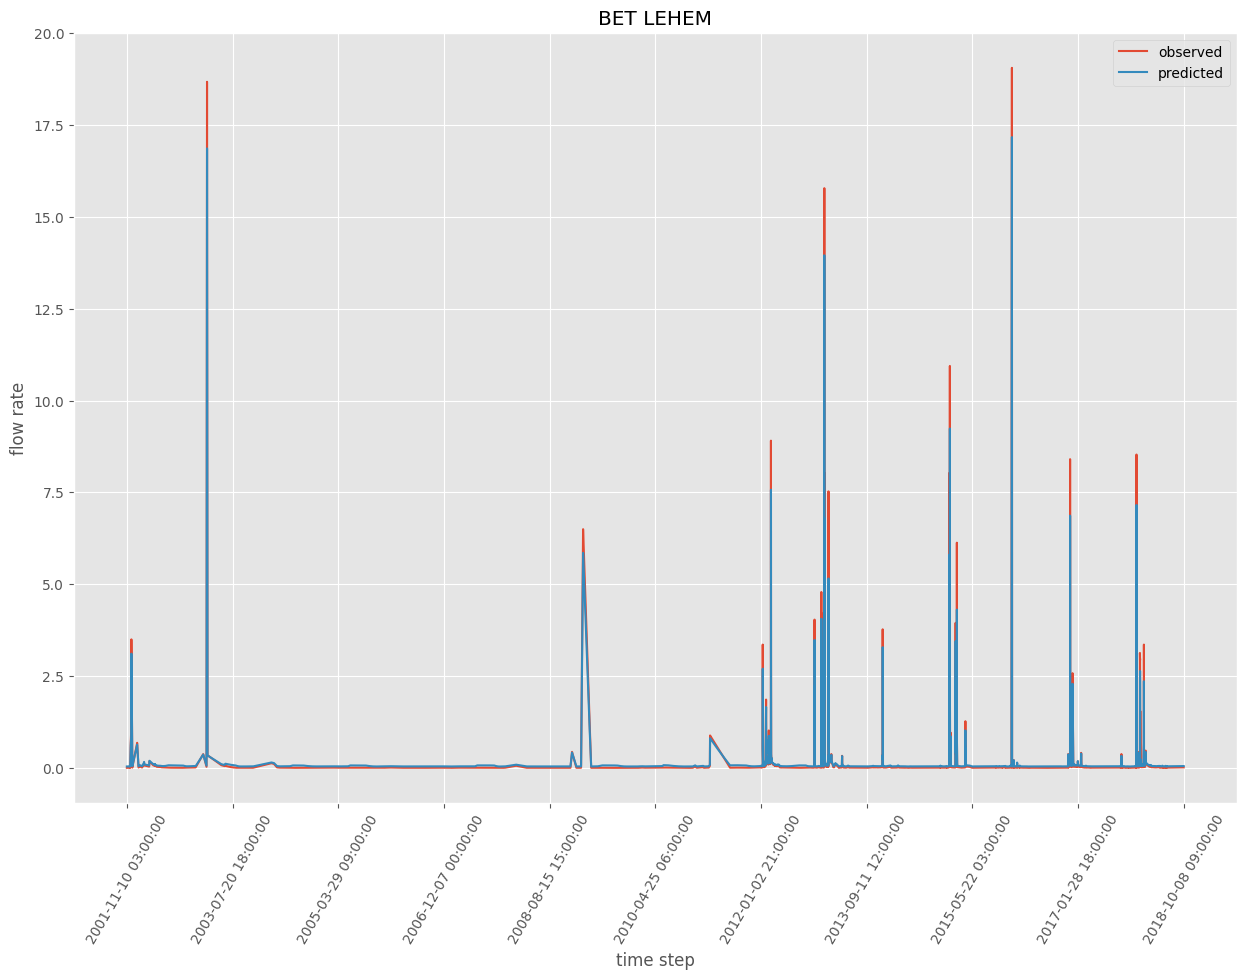

In [ ]:
time_test = list(gauge_df.reset_index(inplace=False).iloc[n_train_sequences+n_hours:, 0].astype('str'))
plot_predicted_vs_observed(model, scaler, test_X, test_y, n_hours, n_features, mean, time_test, gauge_name)

In [ ]:
persist_nse_lstm = history.history['val_persistent_nse_tensor']

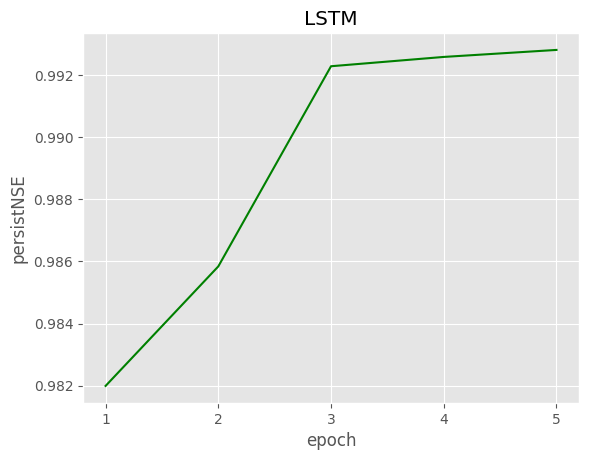

In [ ]:
plt.plot(persist_nse_lstm, c='green')
plt.title('LSTM')
plt.xticks(np.arange(epochs), np.arange(1, epochs+1))
plt.xlabel('epoch')
plt.ylabel('persistNSE')
plt.show()

## GRU

In [ ]:
# number of lag hours
n_hours = l * sequences_per_hour
reframed, scaler = prepare_data(gauge_df, n_hours)

# number of total features
n_features = len(gauge_df.columns)

# drop columns of reframed that are not for prediction
n_cols_reframed = len(reframed.columns)
reframed.drop(reframed.columns[n_cols_reframed-n_features+1:], axis=1, inplace=True)

print(reframed.head())

# split into train and test sets
n_train_sequences = n_train_years * DAYS_PER_YEAR * HOURS_PER_DAY * sequences_per_hour
train_X, train_y, test_X, test_y = split_train_and_test(reframed, n_train_sequences, n_hours, n_features)

   var1(t-3)  var2(t-3)  var1(t-2)  var2(t-2)  var1(t-1)  var2(t-1)   var1(t)
3   0.000375   0.821138   0.000427   0.821545   0.000479   0.821951  0.000532
4   0.000427   0.821545   0.000479   0.821951   0.000532   0.822358  0.000584
5   0.000479   0.821951   0.000532   0.822358   0.000584   0.822764  0.000637
6   0.000532   0.822358   0.000584   0.822764   0.000637   0.823171  0.000689
7   0.000584   0.822764   0.000637   0.823171   0.000689   0.823577  0.000742


In [ ]:
# prepare creating model
metrics = [persistent_nse_tensor, nse_tensor]
create_model = build_model(train_X, nse_star, metrics, GRU)

# run model
model = create_model()
history = model.fit(train_X, train_y, epochs=epochs, batch_size=batch_size, validation_split=validation_split, verbose=2, shuffle=False)

Epoch 1/5
1232/1232 - 6s - loss: 0.2111 - persistent_nse_tensor: 0.5673 - nse_tensor: 0.9610 - val_loss: 0.0035 - val_persistent_nse_tensor: 0.9908 - val_nse_tensor: 0.9994 - 6s/epoch - 5ms/step
Epoch 2/5
1232/1232 - 3s - loss: 0.0957 - persistent_nse_tensor: 0.8003 - nse_tensor: 0.9799 - val_loss: 0.0018 - val_persistent_nse_tensor: 0.9952 - val_nse_tensor: 0.9997 - 3s/epoch - 3ms/step
Epoch 3/5
1232/1232 - 3s - loss: 0.0341 - persistent_nse_tensor: 0.9590 - nse_tensor: 0.9923 - val_loss: 0.0237 - val_persistent_nse_tensor: 0.9376 - val_nse_tensor: 0.9962 - 3s/epoch - 3ms/step
Epoch 4/5
1232/1232 - 3s - loss: 0.0565 - persistent_nse_tensor: 0.8996 - nse_tensor: 0.9881 - val_loss: 1.9435e-04 - val_persistent_nse_tensor: 0.9995 - val_nse_tensor: 1.0000 - 3s/epoch - 3ms/step
Epoch 5/5
1232/1232 - 3s - loss: 0.0306 - persistent_nse_tensor: 0.9637 - nse_tensor: 0.9927 - val_loss: 6.4622e-04 - val_persistent_nse_tensor: 0.9983 - val_nse_tensor: 0.9999 - 3s/epoch - 3ms/step


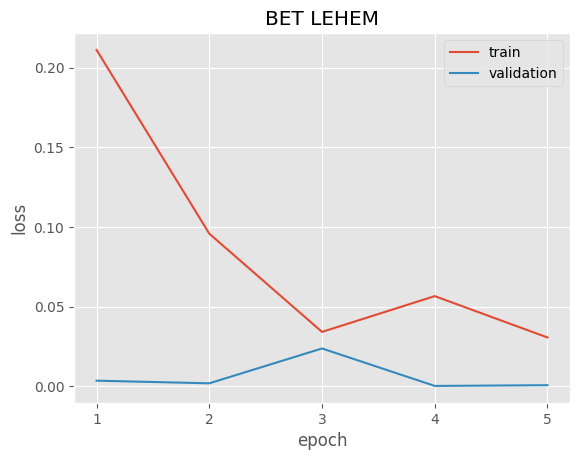

In [ ]:
plot_history(epochs, history, gauge_name)

4633/4633 [==============================] - 8s 2ms/step
Test NSE: 0.960
Test PersistentNSE: 0.961


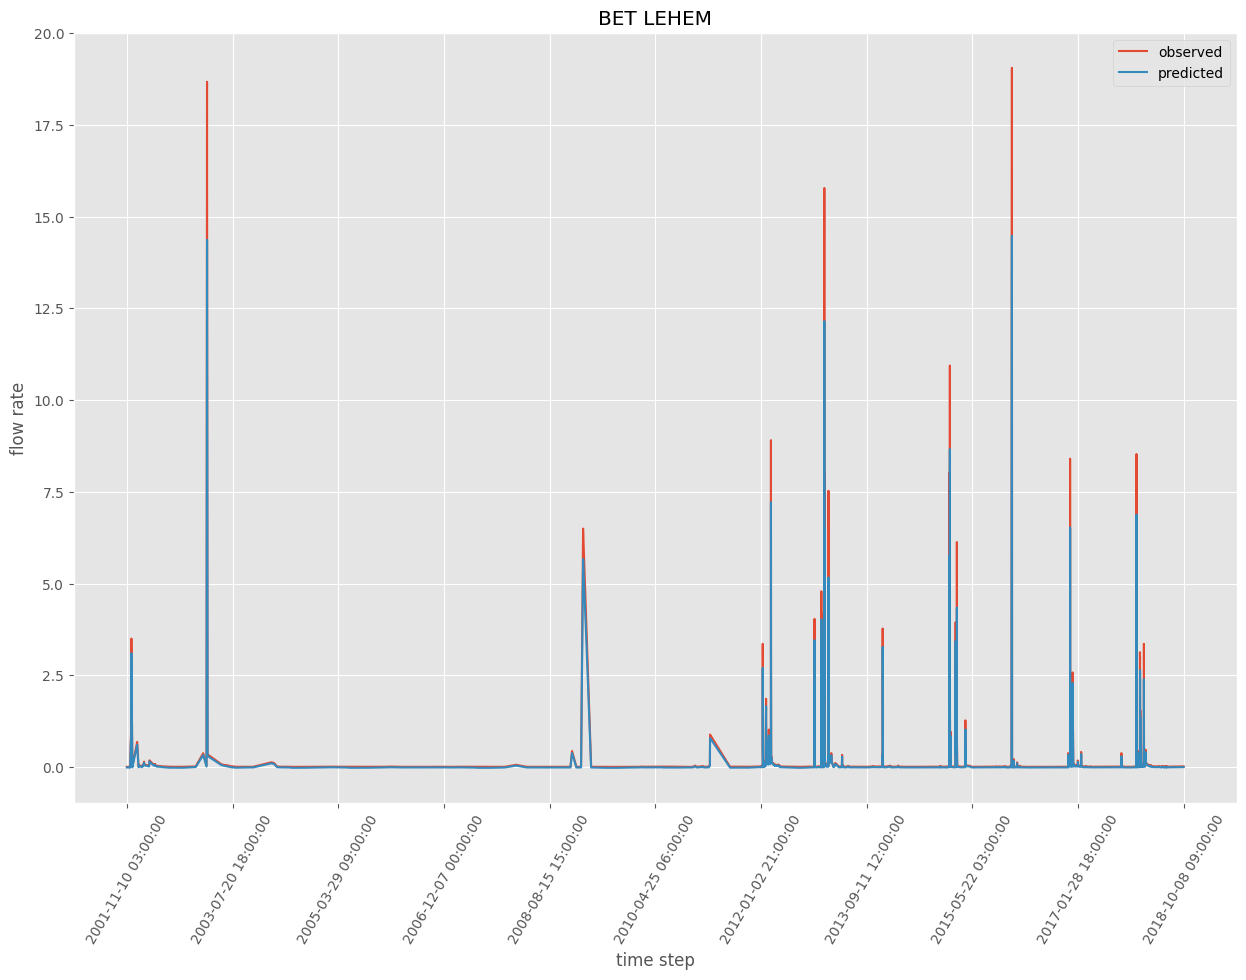

In [ ]:
time_test = list(gauge_df.reset_index(inplace=False).iloc[n_train_sequences+n_hours:, 0].astype('str'))
plot_predicted_vs_observed(model, scaler, test_X, test_y, n_hours, n_features, mean, time_test, gauge_name)

In [ ]:
persist_nse_gru = history.history['val_persistent_nse_tensor']

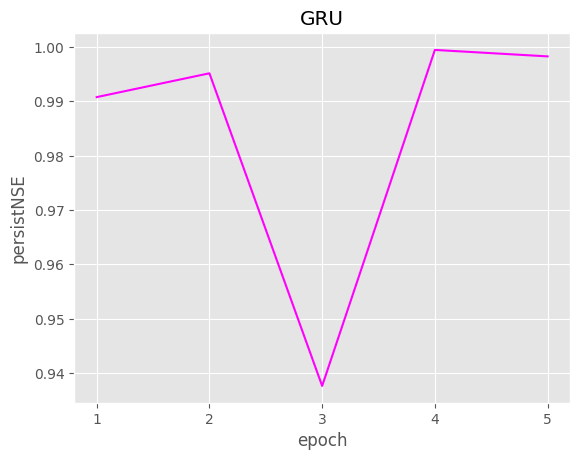

In [ ]:
plt.plot(persist_nse_gru, c='magenta')
plt.title('GRU')
plt.xticks(np.arange(epochs), np.arange(1, epochs+1))
plt.xlabel('epoch')
plt.ylabel('persistNSE')
plt.show()

## LSTM VS GRU

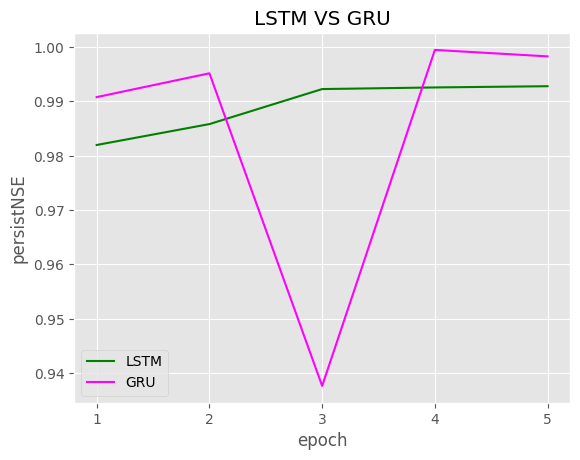

In [ ]:
plt.plot(persist_nse_lstm, label='LSTM', c='green')
plt.plot(persist_nse_gru, label='GRU', c='magenta')
plt.title('LSTM VS GRU')
plt.xticks(np.arange(epochs), np.arange(1, epochs + 1))
plt.xlabel('epoch')
plt.ylabel('persistNSE')
plt.legend()
plt.show()